# Multi-Task Learning Example

This is a simple example to show how to use mxnet for multi-task learning.

The network is jointly going to learn whether a number is odd or even and to actually recognize the digit.


For example

- 1 : 1 and odd
- 2 : 2 and even
- 3 : 3 and odd

etc

In this example we don't expect the tasks to contribute to each other much, but for example multi-task learning has been successfully applied to the domain of image captioning. In [A Multi-task Learning Approach for Image Captioning](https://www.ijcai.org/proceedings/2018/0168.pdf) by Wei Zhao, Benyou Wang, Jianbo Ye, Min Yang, Zhou Zhao, Ruotian Luo, Yu Qiao, they train a network to jointly classify images and generate text captions

In [16]:
import logging
import random
import time

import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, nd, autograd
import numpy as np

### Parameters

In [99]:
batch_size = 128
epochs = 5
ctx = mx.gpu() if len(mx.test_utils.list_gpus()) > 0 else mx.cpu()
lr = 0.01

## Data

We get the traditionnal MNIST dataset and add a new label to the existing one. For each digit we return a new label that stands for Odd or Even

![](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

In [3]:
train_dataset = gluon.data.vision.MNIST(train=True)
test_dataset = gluon.data.vision.MNIST(train=False)

In [4]:
def transform(x,y):
    x = x.transpose((2,0,1)).astype('float32')/255.
    y1 = y
    y2 = y % 2 #odd or even
    return x, np.float32(y1), np.float32(y2)

We assign the transform to the original dataset

In [5]:
train_dataset_t = train_dataset.transform(transform)
test_dataset_t = test_dataset.transform(transform)

We load the datasets DataLoaders

In [6]:
train_data = gluon.data.DataLoader(train_dataset_t, shuffle=True, last_batch='rollover', batch_size=batch_size, num_workers=5)
test_data = gluon.data.DataLoader(test_dataset_t, shuffle=False, last_batch='rollover', batch_size=batch_size, num_workers=5)

In [7]:
print("Input shape: {}, Target Labels: {}".format(train_dataset[0][0].shape, train_dataset_t[0][1:]))

Input shape: (28, 28, 1), Target Labels: (5.0, 1.0)


## Multi-task Network

The output of the featurization is passed to two different outputs layers

In [135]:
class MultiTaskNetwork(gluon.HybridBlock):
    
    def __init__(self):
        super(MultiTaskNetwork, self).__init__()
        
        self.shared = gluon.nn.HybridSequential()
        with self.shared.name_scope():
            self.shared.add(
                gluon.nn.Dense(128, activation='relu'),
                gluon.nn.Dense(64, activation='relu'),
                gluon.nn.Dense(10, activation='relu')
            )
        self.output1 = gluon.nn.Dense(10) # Digist recognition
        self.output2 = gluon.nn.Dense(1) # odd or even

        
    def hybrid_forward(self, F, x):
        y = self.shared(x)
        output1 = self.output1(y)
        output2 = self.output2(y)
        return output1, output2

We can use two different losses, one for each output

In [136]:
loss_digits = gluon.loss.SoftmaxCELoss()
loss_odd_even = gluon.loss.SigmoidBCELoss()

We create and initialize the network

In [137]:
mx.random.seed(42)
random.seed(42)

In [138]:
net = MultiTaskNetwork()

In [139]:
net.initialize(mx.init.Xavier(), ctx=ctx)
net.hybridize() # hybridize for speed

In [140]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate':lr})

## Evaluate Accuracy
We need to evaluate the accuracy of each task separately

In [141]:
def evaluate_accuracy(net, data_iterator):
    acc_digits = mx.metric.Accuracy(name='digits')
    acc_odd_even = mx.metric.Accuracy(name='odd_even')
    
    for i, (data, label_digit, label_odd_even) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label_digit = label_digit.as_in_context(ctx)
        label_odd_even = label_odd_even.as_in_context(ctx).reshape(-1,1)

        output_digit, output_odd_even = net(data)
        
        acc_digits.update(label_digit, output_digit.softmax())
        acc_odd_even.update(label_odd_even, output_odd_even.sigmoid() > 0.5)
    return acc_digits.get(), acc_odd_even.get()

## Training Loop

We need to balance the contribution of each loss to the overall training and do so by tuning this alpha parameter within [0,1].

In [142]:
alpha = 0.5 # Combine losses factor

In [143]:
for e in range(epochs):
    # Accuracies for each task
    acc_digits = mx.metric.Accuracy(name='digits')
    acc_odd_even = mx.metric.Accuracy(name='odd_even')
    # Accumulative losses
    l_digits_ = 0.
    l_odd_even_ = 0. 
    
    for i, (data, label_digit, label_odd_even) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label_digit = label_digit.as_in_context(ctx)
        label_odd_even = label_odd_even.as_in_context(ctx).reshape(-1,1)
        
        with autograd.record():
            output_digit, output_odd_even = net(data)
            l_digits = loss_digits(output_digit, label_digit)
            l_odd_even = loss_odd_even(output_odd_even, label_odd_even)

            # Combine the loss of each task
            l_combined = (1-alpha)*l_digits + alpha*l_odd_even
            
        l_combined.backward()
        trainer.step(data.shape[0])
        
        l_digits_ += l_digits.mean()
        l_odd_even_ += l_odd_even.mean()
        acc_digits.update(label_digit, output_digit.softmax())
        acc_odd_even.update(label_odd_even, output_odd_even.sigmoid() > 0.5)
        
    print("Epoch [{}], Acc Digits   {:.4f} Loss Digits   {:.4f}".format(
        e, acc_digits.get()[1], l_digits_.asscalar()/(i+1)))
    print("Epoch [{}], Acc Odd/Even {:.4f} Loss Odd/Even {:.4f}".format(
        e, acc_odd_even.get()[1], l_odd_even_.asscalar()/(i+1)))
    print("Epoch [{}], Testing Accuracies {}".format(e, evaluate_accuracy(net, test_data)))
        

Epoch [0], Acc Digits   0.8945 Loss Digits   0.3409
Epoch [0], Acc Odd/Even 0.9561 Loss Odd/Even 0.1152
Epoch [0], Testing Accuracies (('digits', 0.9487179487179487), ('odd_even', 0.9770633012820513))
Epoch [1], Acc Digits   0.9576 Loss Digits   0.1475
Epoch [1], Acc Odd/Even 0.9804 Loss Odd/Even 0.0559
Epoch [1], Testing Accuracies (('digits', 0.9642427884615384), ('odd_even', 0.9826722756410257))
Epoch [2], Acc Digits   0.9681 Loss Digits   0.1124
Epoch [2], Acc Odd/Even 0.9852 Loss Odd/Even 0.0418
Epoch [2], Testing Accuracies (('digits', 0.9580328525641025), ('odd_even', 0.9846754807692307))
Epoch [3], Acc Digits   0.9734 Loss Digits   0.0961
Epoch [3], Acc Odd/Even 0.9884 Loss Odd/Even 0.0340
Epoch [3], Testing Accuracies (('digits', 0.9670472756410257), ('odd_even', 0.9839743589743589))
Epoch [4], Acc Digits   0.9762 Loss Digits   0.0848
Epoch [4], Acc Odd/Even 0.9894 Loss Odd/Even 0.0310
Epoch [4], Testing Accuracies (('digits', 0.9652887658227848), ('odd_even', 0.98585838607594

## Testing

In [144]:
def get_random_data():
    idx = random.randint(0, len(test_dataset))

    img = test_dataset[idx][0]
    data, _, _ = test_dataset_t[idx]
    data = data.as_in_context(ctx).expand_dims(axis=0)

    plt.imshow(img.squeeze().asnumpy(), cmap='gray')
    
    return data

Predicted digit: [9.], odd: [1.]


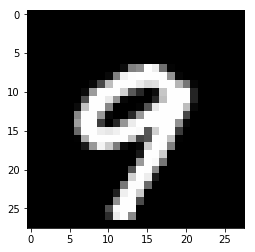

In [152]:
data = get_random_data()

digit, odd_even = net(data)

digit = digit.argmax(axis=1)[0].asnumpy()
odd_even = (odd_even.sigmoid()[0] > 0.5).asnumpy()

print("Predicted digit: {}, odd: {}".format(digit, odd_even))